# Gaussian Process Input Error Algorithms

In [1]:
import sys
sys.path.insert(0, '/Users/eman/Documents/code_projects/gp_error')
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/projects/gp_error')

from kernellib.visualization import plot_gp
from kernellib.utils import r_assessment
from kernellib.gpr_error import GPRVariance

from gp_error.approximate import GPRTaylorApprox
from gp_error.gaussianprocess import GPErrorNumerical
from sklearn.gaussian_process.kernels import (
    ConstantKernel as C, RBF, WhiteKernel)
from gp_extras.kernels import HeteroscedasticKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import interpolate
import pandas as pd
# from gp_error.gaussianprocess import GPUncertainty
from gp_error.data import example_1d
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig_save = "/home/emmanuel/projects/gp_error/figures/1d_example/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

/Users/eman/anaconda3/envs/gperror/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Sample Data

/Users/eman/anaconda3/envs/gperror/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


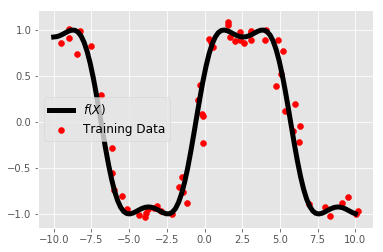

In [4]:
sample_func = 1
x_error = 0.3
X, y, error_params = example_1d(sample_func, x_error)

fig, ax = plt.subplots()
ax.scatter(X['train'], y['train'], color='r', label='Training Data')
ax.plot(X['plot'], y['plot'], linewidth=5, color='k', label=r'$f(X)$')

ax.legend(loc='best', fontsize=12)
plt.show()
# fig.savefig(fig_save + 'data' + '.png', bbox_inhces='tight',
#             dpi=100, frameon=None)

In [5]:
def plot_gp(predictions, variances, X, title=None, save_name=None):

    fig, ax = plt.subplots()
    ax.scatter(X['train'], y['train'], s=100, color='r', label='Training Data')
    ax.plot(X['plot'], predictions, linewidth=5,
            color='k', label='Predictions')
    ax.fill_between(
        X['plot'].squeeze(),
        predictions.squeeze() + 2*variances.squeeze(),
        predictions.squeeze() - 2*variances.squeeze(),
        color='red', alpha=0.2, label='Condidence'
    )
    ax.legend()
    plt.show()

#     if save_name is not None:
#         fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
#                     dpi=100, frameon=None)

    return None

## Experiment I - Error In Predictions

In [6]:
gp_models = dict()
predictions = dict()
standard_dev = dict()
mse = dict()
mae = dict()
rmse = dict()

### Standard GP Model

In [7]:
# Their GP
kernel = C() * RBF() + WhiteKernel()
sk_gp_model = GaussianProcessRegressor(kernel=kernel)
sk_gp_model.fit(X['train'], y['train'])
sk_mean, sk_std = sk_gp_model.predict(X['test'], return_std=True)

r_assessment(sk_mean, y['test'], verbose=True);

0.030893258710912686
0.1195073117857016


In [8]:
%timeit sk_gp_model.predict(X['plot'], return_std=True)

332 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%memit sk_gp_model.predict(X['plot'], return_std=True)

peak memory: 155.31 MiB, increment: 0.02 MiB


In [10]:
predictions['standard'], standard_dev['standard'] = \
    sk_gp_model.predict(X['plot'], return_std=True)

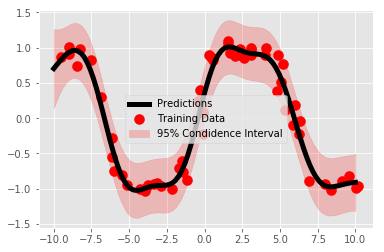

In [11]:
plot_gp(X['plot'], predictions['standard'],
        standard_dev['standard'], X['train'], y['train']);

### Random Forest Regressor

In [34]:
from sklearn.model_selection import GridSearchCV

0.04979430041825573
0.1437584966380178


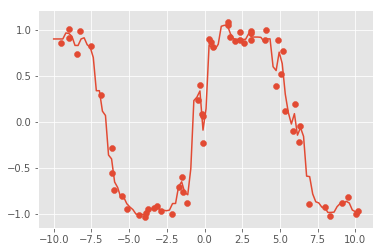

In [48]:
# create RandomForestRegressor
param_grid = {
    'n_estimators': [1, 2, 5, 10, 25, 50],
    
}
n_trees = 10

rf_clf = RandomForestRegressor(n_estimators=200, random_state=123, 
                               max_depth=10, max_features=1)
rf_clf.fit(X['train'], y['train'].flatten())
y_pred = rf_clf.predict(X['test'])

mse['rf'] = mean_squared_error(y_pred, y['test'])
mae['rf'] = mean_absolute_error(y_pred, y['test'])
print(mse['rf'])
print(mae['rf'])

mean = rf_clf.predict(X['plot'])

fig, ax = plt.subplots()

ax.scatter(X['train'], y['train'])
ax.plot(X['plot'], mean)

### My GP Error Model (Enhanced Predictive Variance)

In [7]:
from kernellib.autogp_error import GPRMean

In [26]:
# mgp_model = GPRMean(x_cov=error_params['x'], n_iters=20)

# mgp_model.fit(X['train'], y['train'])
# # mgp_mean, mgp_std = mgp_model.predict(X['test'], return_std=True)

# # mse['stnd'] = mean_squared_error(sk_mean, y['test'])
# # mae['stnd'] = mean_absolute_error(sk_mean, y['test'])
# # print(mse['stnd'])
# # print(mae['stnd'])


### My GP Error Model (Standard Predictive Variance)

In [27]:

%autoreload 2

In [7]:
# My GP

kernel = sk_gp_model.kernel_

mygp_clf = GPRVariance(kernel=kernel, x_cov=0.3)
mygp_clf.fit(X['train'], y['train'])

mean, std = mygp_clf.predict(X['test'], return_std=True)
r_assessment(mean, y['test'], verbose=True);

MAE: 0.120
MSE: 0.031
RMSE: 0.176
R2: 0.951


In [36]:
%timeit mygp_clf.predict(X['plot'], return_std=True)

328 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [37]:
%memit mygp_clf.predict(X['plot'], return_std=True)

peak memory: 195.13 MiB, increment: 0.70 MiB


In [8]:
predictions['var'], standard_dev['var'] = \
    mygp_clf.predict(X['plot'], return_std=True)

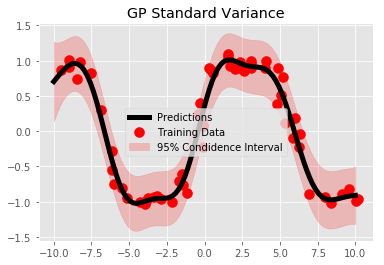

In [9]:
plot_gp(X['plot'], predictions['var'],
        standard_dev['var'], X['train'], y['train'], title='GP Standard Variance');

### GP + Mean Variance

In [10]:
mygp_mean = GPRVariance(kernel=kernel, x_cov=0.3, var_method='mean')
mygp_mean.fit(X['train'], y['train'])

mean, std = mygp_mean.predict(X['test'], return_std=True)
r_assessment(mean, y['test'], verbose=True);

MAE: 0.120
MSE: 0.031
RMSE: 0.176
R2: 0.951


In [41]:
%timeit mygp_mean.predict(X['plot'], return_std=True)

464 µs ± 550 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [42]:
%memit mygp_mean.predict(X['plot'], return_std=True)

peak memory: 195.15 MiB, increment: -0.39 MiB


In [11]:
predictions['mean'], standard_dev['mean'] = \
    mygp_mean.predict(X['plot'], return_std=True)

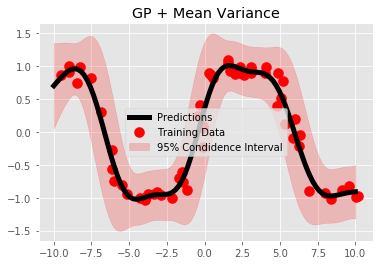

In [12]:
plot_gp(X['plot'], predictions['mean'], standard_dev['mean'], 
        X['train'], y['train'], title='GP + Mean Variance');

### GP + Uncertainty Variance

In [22]:
mygp_unc = GPRVariance(kernel=kernel, x_cov=0.3, normalize_y=True, mean='uncertain', weights='derivative', var_method='uncertain')
mygp_unc.fit(X['train'], y['train'])

mean, std = mygp_unc.predict(X['test'], return_std=True)
r_assessment(mean, y['test'], verbose=True);

MAE: 0.141
MSE: 0.038
RMSE: 0.196
R2: 0.933


In [46]:
%timeit mygp_unc.predict(X['plot'], return_std=True)

18.4 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
%memit mygp_unc.predict(X['plot'], return_std=True)

peak memory: 198.28 MiB, increment: -0.40 MiB


In [23]:
predictions['uncertain'], standard_dev['uncertain'] = \
    mygp_unc.predict(X['plot'], return_std=True)

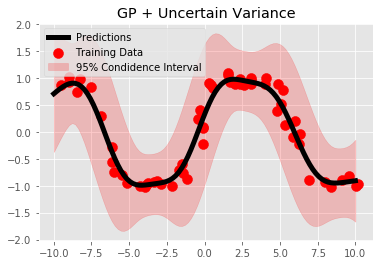

In [24]:
plot_gp(X['plot'], predictions['uncertain'], standard_dev['uncertain'], 
        X['train'], y['train'], title='GP + Uncertain Variance');

### GP + Uncertain Mean & Uncertainty

In [108]:
mygp_munc = GPRVariance(kernel=kernel, x_cov=0.3, var_method='uncertain', mean='uncertain')
mygp_munc.fit(X['train'], y['train'])

mean, std = mygp_munc.predict(X['test'], return_std=True)
r_assessment(mean, y['test'], verbose=True);

(60, 1) (60, 60) (60, 1) (1, 1)
MAE: 0.141
MSE: 0.039
RMSE: 0.196
R2: 0.933


In [93]:
%timeit mygp_munc.predict(X['plot'], return_std=True)

16.8 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
%memit mygp_munc.predict(X['plot'], return_std=True)

peak memory: 203.64 MiB, increment: -0.40 MiB


In [109]:
predictions['muncertain'], standard_dev['muncertain'] = \
    mygp_munc.predict(X['plot'], return_std=True)

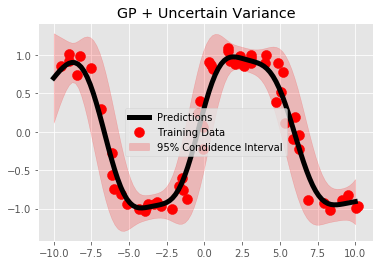

In [110]:


plot_gp(X['plot'], predictions['muncertain'], standard_dev['muncertain'], 
        X['train'], y['train'], title='GP + Uncertain Variance');

### Gaussian Process (Taylor Expansion)

In [57]:
# My GP
kernel = sk_gp_model.kernel_
agp_model = GPRTaylorApprox(kernel=sk_gp_model.kernel_, x_cov=0.3)
agp_model.fit(X['train'], y['train'])
mean, std = \
    agp_model.predict(X['test'], return_std=True)

mse['taylor'] = mean_squared_error(mean, y['test'])
mae['taylor'] = mean_absolute_error(mean, y['test'])
print(mse['taylor'])
print(mae['taylor'])

0.030893258710912547
0.11950731178570125


In [58]:
%timeit agp_model.predict(X['plot'], return_std=True)

15.8 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%memit agp_model.predict(X['plot'], return_std=True)

peak memory: 198.73 MiB, increment: 0.02 MiB


In [60]:
predictions['taylor'], standard_dev['taylor'] = \
    agp_model.predict(X['plot'], return_std=True)

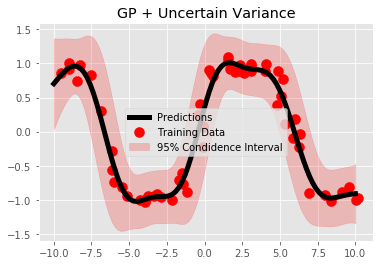

In [62]:
plot_gp(X['plot'], predictions['taylor'], standard_dev['taylor'], 
        X['train'], y['train'], title='GP + Uncertain Variance');

### Gaussian Process Algorithm (Heteroscedastic Noise Model)

In [63]:
# Their GP
prototypes = KMeans(n_clusters=10).fit(X['train']).cluster_centers_
kernel = C() * RBF() + HeteroscedasticKernel.construct(prototypes)
skh_gp_model = GaussianProcessRegressor(kernel=kernel)
skh_gp_model.fit(X['train'], y['train'])
skh_mean, skh_std = skh_gp_model.predict(X['plot'], return_std=True)

In [64]:
%timeit skh_gp_model.predict(X['plot'], return_std=True)

2.04 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
%memit skh_gp_model.predict(X['plot'], return_std=True)

peak memory: 198.89 MiB, increment: 0.00 MiB


In [66]:
predictions['hetero'], standard_dev['hetero'] = \
    skh_gp_model.predict(X['plot'], return_std=True)

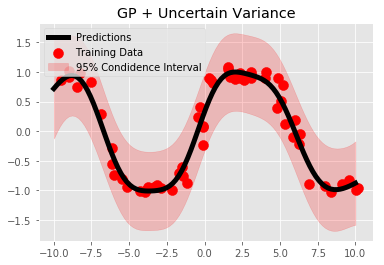

In [68]:
plot_gp(X['plot'], predictions['hetero'], standard_dev['hetero'], 
        X['train'], y['train'], title='GP + Uncertain Variance');

### Error Propagation (Approximate Integral)

In [89]:
gp_errmodel = GPErrorNumerical(sk_gp_model, x_error=x_error, order=4)
gp_errmodel.fit(X['train'], y['train'])
output_mean, out_std = gp_errmodel.predict(X['plot'], return_std=True)

In [82]:
%timeit gp_errmodel.predict(X['plot'], return_std=True)

1.78 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%memit gp_errmodel.predict(X['plot'], return_std=True)

peak memory: 198.98 MiB, increment: 0.00 MiB


In [90]:
predictions['numerical'], standard_dev['numerical'] = \
    gp_errmodel.predict(X['plot'], return_std=True)

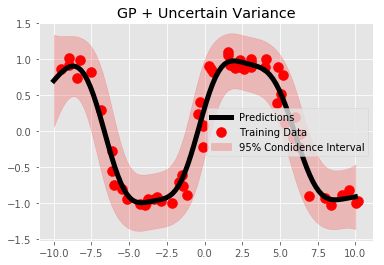

In [91]:
plot_gp(X['plot'], predictions['numerical'], standard_dev['numerical'], 
        X['train'], y['train'], title='GP + Uncertain Variance');

## Empirical Variance

In [121]:
Models = [
    sk_gp_model,
    mygp_clf,
    skh_gp_model,
    agp_model,
    gp_errmodel
]

In [122]:
def empirical_variance_exp(models, X, error_params, x_error=None,
                           n_points=1000, n_trials=100):

    rng = np.random.RandomState(None)

    f = error_params['f']
    sigmay = error_params['y']
    if x_error is None:
        x_error = error_params['x']

    mae_score = {
        'simple': list(),
        'var': list(),
        'hetero': list(),
        'approx': list(),
        'num': list()
    }

    mse_score = {
        'simple': list(),
        'var': list(),
        'hetero': list(),
        'approx': list(),
        'num': list()
    }

    abs_error = {
        'simple': list(),
        'var': list(),
        'hetero': list(),
        'approx': list(),
        'num': list()
    }
    squared_error = {
        'simple': list(),
        'var': list(),
        'hetero': list(),
        'approx': list(),
        'num': list()
    }

    x = np.linspace(-10, 10, n_points)

    # Testing set (noise-less)
    ytest = f(x)
    ytest += sigmay * rng.randn(n_points)
    ytest = ytest[:, np.newaxis]
    batch_size = 20
    n_jobs = 10

    for itrial in range(n_trials):
        if itrial % 100 == 0:
            print('Trial: {}'.format(itrial + 1))

        # Generate x samples with random error
        xtest = x + x_error * rng.randn(n_points)
        xtest = xtest[:, np.newaxis]

        #---------------
        # MODEL I
        #---------------
        mean = models[0].predict(xtest)

        abs_error['simple'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['simple'].append((mean.squeeze() - ytest.squeeze())**2)
        mae_score['simple'].append(
            mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['simple'].append(
            mean_squared_error(mean.squeeze(), ytest.squeeze()))
        #---------------
        # MODEL II
        #---------------
        mean = models[1].predict(xtest)

        abs_error['var'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['var'].append((mean.squeeze() - ytest.squeeze())**2)
        mae_score['var'].append(mean_absolute_error(
            mean.squeeze(), ytest.squeeze()))
        mse_score['var'].append(mean_squared_error(
            mean.squeeze(), ytest.squeeze()))
        #---------------
        # MODEL III
        #---------------
        mean = models[2].predict(xtest)

        abs_error['hetero'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['hetero'].append((mean.squeeze() - ytest.squeeze())**2)
        mae_score['hetero'].append(
            mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['hetero'].append(
            mean_squared_error(mean.squeeze(), ytest.squeeze()))
        #---------------
        # MODEL I
        #---------------
        mean = models[3].predict(xtest)

        abs_error['approx'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['approx'].append((mean.squeeze() - ytest.squeeze())**2)
        mae_score['approx'].append(
            mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['approx'].append(
            mean_squared_error(mean.squeeze(), ytest.squeeze()))
        
        #---------------
        # MODEL I
        #---------------
        mean = models[4].predict(xtest)

        abs_error['num'].append(np.abs(mean.squeeze() - ytest.squeeze()))
        squared_error['num'].append((mean.squeeze() - ytest.squeeze())**2)
        mae_score['num'].append(
            mean_absolute_error(mean.squeeze(), ytest.squeeze()))
        mse_score['num'].append(
            mean_squared_error(mean.squeeze(), ytest.squeeze()))

    # Convert to arrays
    abs_error['simple'] = np.array(abs_error['simple'])
    squared_error['simple'] = np.array(squared_error['simple'])
    mae_score['simple'] = np.array(mae_score['simple'])
    mse_score['simple'] = np.array(mse_score['simple'])

    abs_error['var'] = np.array(abs_error['var'])
    squared_error['exact'] = np.array(squared_error['var'])
    mae_score['var'] = np.array(mae_score['var'])
    mse_score['var'] = np.array(mse_score['var'])

    abs_error['hetero'] = np.array(abs_error['hetero'])
    squared_error['hetero'] = np.array(squared_error['hetero'])
    mae_score['hetero'] = np.array(mae_score['hetero'])
    mse_score['hetero'] = np.array(mse_score['hetero'])

    abs_error['approx'] = np.array(abs_error['approx'])
    squared_error['approx'] = np.array(squared_error['approx'])
    mae_score['approx'] = np.array(mae_score['approx'])
    mse_score['approx'] = np.array(mse_score['approx'])
    
    abs_error['num'] = np.array(abs_error['num'])
    squared_error['num'] = np.array(squared_error['num'])
    mae_score['num'] = np.array(mae_score['num'])
    mse_score['num'] = np.array(mse_score['num'])

    return abs_error, squared_error, mae_score, mse_score

In [123]:
%%time

abs_error, squared_error, mae_score, mse_score = \
    empirical_variance_exp(Models, X, error_params, n_trials=100)

Trial: 1
CPU times: user 2min 49s, sys: 12min 47s, total: 15min 37s
Wall time: 2min 3s


In [124]:
avg_abs_error = dict()
avg_squared_error = dict()
avg_mae_score = dict()
avg_mse_score = dict()


avg_abs_error['simple'] = np.mean(
    np.array(abs_error['simple']).squeeze(), axis=0)
avg_squared_error['simple'] = np.mean(
    np.array(squared_error['simple']).squeeze(), axis=0)
avg_mae_score['simple'] = np.mean(np.array(mae_score['simple']))
avg_mse_score['simple'] = np.mean(np.array(mse_score['simple']))

avg_abs_error['var'] = np.mean(np.array(abs_error['var']).squeeze(), axis=0)
avg_squared_error['var'] = np.mean(
    np.array(squared_error['var']).squeeze(), axis=0)
avg_mae_score['var'] = np.mean(np.array(mae_score['var']))
avg_mse_score['var'] = np.mean(np.array(mse_score['var']))

avg_abs_error['hetero'] = np.mean(
    np.array(abs_error['hetero']).squeeze(), axis=0)
avg_squared_error['hetero'] = np.mean(
    np.array(squared_error['hetero']).squeeze(), axis=0)
avg_mae_score['hetero'] = np.mean(np.array(mae_score['hetero']))
avg_mse_score['hetero'] = np.mean(np.array(mse_score['hetero']))


avg_abs_error['approx'] = np.mean(
    np.array(abs_error['approx']).squeeze(), axis=0)
avg_squared_error['approx'] = np.mean(
    np.array(squared_error['approx']).squeeze(), axis=0)
avg_mae_score['approx'] = np.mean(np.array(mae_score['approx']))
avg_mse_score['approx'] = np.mean(np.array(mse_score['approx']))

avg_abs_error['num'] = np.mean(
    np.array(abs_error['num']).squeeze(), axis=0)
avg_squared_error['num'] = np.mean(
    np.array(squared_error['num']).squeeze(), axis=0)
avg_mae_score['num'] = np.mean(np.array(mae_score['num']))
avg_mse_score['num'] = np.mean(np.array(mse_score['num']))

### Plotting the Empirical Variance

#### Standard GP

In [125]:
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

In [140]:
def plot_empirical_density_map(model, squared_error, sample=1000, save_name=None):
    
    x = np.linspace(-10, 10, 1000)
    x = np.repeat(x, len(squared_error))
    y = np.vstack([squared_error]).flatten()
    
    # sample
    x, _, y, _ = train_test_split(x, y, train_size=sample, random_state=100)
    xy = np.vstack([x, y])
    nbins = 20
    k = gaussian_kde(xy)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    # add shading
    fig, ax = plt.subplots()
#     ax.set_title('2D Density with shading')
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='jet')
    plt.show()

    
    
    return None

In [141]:
def plot_empirical_density_points(model, squared_error, sample=1000, save_name=None):
    
    xplot = np.linspace(-10, 10, 1000)
    

    
    x = np.repeat(xplot, len(squared_error))
    y = np.vstack([squared_error]).flatten()
    
    # sample
    x, _, y, _ = train_test_split(x, y, train_size=sample, random_state=123)
    
    xy = np.vstack([x, y])

    k = gaussian_kde(xy)
    z = k(xy)

    idx = z.argsort()

    xi, yi, z = x[idx], y[idx], z[idx]
    pred, std = model.predict(xplot[:, np.newaxis], return_std=True)
    print(pred.shape, std.shape, xplot.shape)
    # add shading
    fig, ax = plt.subplots()
    ax.scatter(xi, yi, c=z, s=10, cmap=plt.cm.jet, edgecolor='', label='None', picker=True, zorder=2)    
    ax.plot(xplot, std**2, linewidth=4, color='k', label='Predictive Variance')
    ax.legend(fontsize=10)
    ax.grid(True)
    plt.show()
    
    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, frameon=None)
    
    
    return None

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


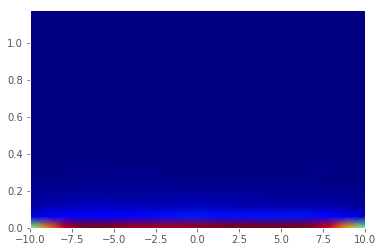

(1000, 1) (1000,) (1000,)


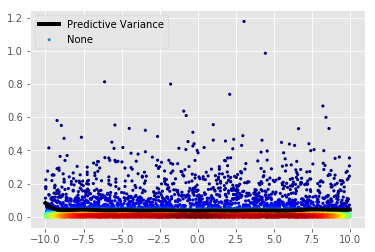

In [142]:
plot_empirical_density_map(sk_gp_model, squared_error['simple'], 5000, save_name='gp_em_stand')
plot_empirical_density_points(sk_gp_model, squared_error['simple'], 7000, save_name='gp_em_stand')

In [143]:
def plot_empirical_error(model, squared_error, save_name=None):

    x = np.linspace(-10, 10, 1000)

    fig, ax = plt.subplots()

    pred, std = model.predict(x[:, np.newaxis], return_std=True)

    for sq_err in squared_error:
        ax.scatter(x, sq_err, s=0.05, color='k')

    ax.plot(x, std**2, linewidth=4, color='r', label='Predictive Variance')
    ax.legend(fontsize=14)
    ax.grid(True)
    plt.show()

    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, frameon=None)

    return None

In [144]:
def plot_avgempirical_error(model, avg_squared_error, save_name=None):

    x = np.linspace(-10, 10, 1000)
    sigma_y = model.kernel_.get_params()['k2__noise_level']
    pred, std = model.predict(x[:, np.newaxis], return_std=True)

    squared_error_line = interpolate.interp1d(
        x, avg_squared_error, kind='slinear')(x)

    fig, ax = plt.subplots()

    ax.plot(x, squared_error_line, linewidth=2,
            color='k', label='Average Squared Error')
    ax.plot(x, std**2 - sigma_y, linewidth=4, color='r', label='Predictive Variance')
    ax.legend(['Mean Squared Error', 'Predictive Variance'], fontsize=10)
    ax.grid(True)
    plt.show()

    if save_name is not None:
        fig.savefig(fig_save + save_name + '.png', bbox_inhces='tight',
                    dpi=100, frameon=None)

    return None

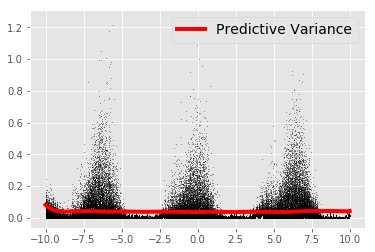

In [145]:
plot_empirical_error(sk_gp_model, squared_error['simple'], 'gp_em_stand')

In [146]:
plot_empirical_density_points(sk_gp_model, squared_error['simple'], 10000, save_name='gp_em_dens_stand')

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1000, 1) (1000,) (1000,)


In [147]:
plot_avgempirical_error(
    sk_gp_model, avg_squared_error['simple'], 'gp_avg_em_stand')

#### GP with Custom Variance

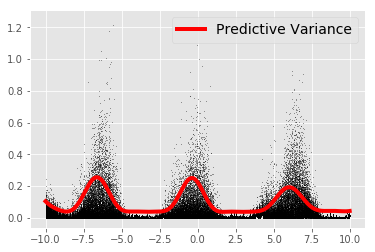

In [148]:
plot_empirical_error(mygp_clf, squared_error['var'], 'gp_em_var')

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1000, 1) (1000,) (1000,)


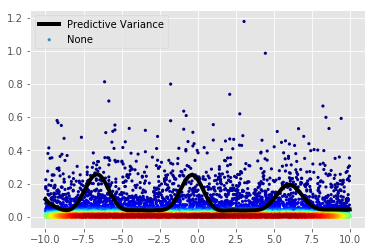

In [149]:
plot_empirical_density_points(mygp_clf, squared_error['var'], 10000, save_name='gp_em_dens_var')

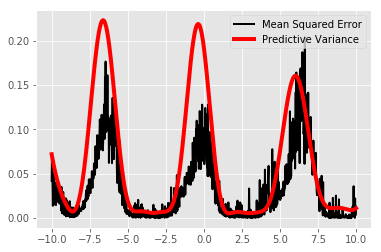

In [150]:
plot_avgempirical_error(mygp_clf, avg_squared_error['var'], 'gp_avg_em_var')

#### Heteroscedastic Model

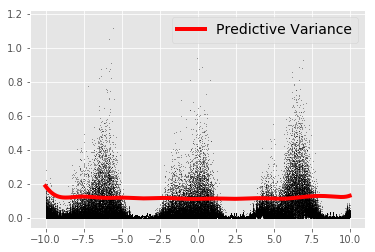

In [151]:
plot_empirical_error(skh_gp_model, squared_error['hetero'], 'gp_em_hetero')

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1000, 1) (1000,) (1000,)


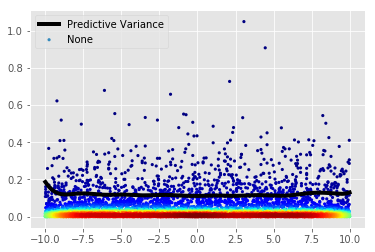

In [152]:
plot_empirical_density_points(skh_gp_model, squared_error['hetero'], 7000, save_name='gp_em_dens_hetero')

In [153]:
plot_avgempirical_error(
    skh_gp_model, avg_squared_error['hetero'], 'gp_avg_em_hetero')

KeyError: 'k2__noise_level'

#### Approximate Uncertainty

In [ ]:
plot_empirical_error(agp_model, squared_error['approx'], 'gp_em_approx')

In [ ]:
plot_empirical_density_points(agp_model, squared_error['approx'], 7000, save_name='gp_em_dens_approx')

In [ ]:
plot_avgempirical_error(
    agp_model, avg_squared_error['approx'], 'gp_avg_em_approx')

#### Numerical Uncertainty

In [ ]:
plot_empirical_error(gp_errmodel, squared_error['num'], 'gp_em_num')

In [ ]:
plot_empirical_density_points(gp_errmodel, squared_error['num'], 7000, save_name='gp_em_dens_num')

In [ ]:
plot_avgempirical_error(
    gp_errmodel, avg_squared_error['num'], 'gp_avg_em_num')